# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Defining-a-gene-compactifier-for-easy-printing" data-toc-modified-id="Defining-a-gene-compactifier-for-easy-printing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Defining a gene compactifier for easy printing</a></div><div class="lev1 toc-item"><a href="#Effects-of-HIF-1-on-mitochondrial-proteins" data-toc-modified-id="Effects-of-HIF-1-on-mitochondrial-proteins-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Effects of HIF-1 on mitochondrial proteins</a></div><div class="lev1 toc-item"><a href="#HIF-1-effects-on-the-ribosome" data-toc-modified-id="HIF-1-effects-on-the-ribosome-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>HIF-1 effects on the ribosome</a></div><div class="lev1 toc-item"><a href="#Bioenergetics-of-HIF-1" data-toc-modified-id="Bioenergetics-of-HIF-1-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bioenergetics of HIF-1</a></div><div class="lev1 toc-item"><a href="#Effects-of-HIF-1-on-the-Proteasome-and-Mediator" data-toc-modified-id="Effects-of-HIF-1-on-the-Proteasome-and-Mediator-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Effects of HIF-1 on the Proteasome and Mediator</a></div><div class="lev2 toc-item"><a href="#Effect-of-HIF-1-on-proteins-involved-in-'protein-catabolic-process'" data-toc-modified-id="Effect-of-HIF-1-on-proteins-involved-in-'protein-catabolic-process'-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Effect of HIF-1 on proteins involved in 'protein catabolic process'</a></div><div class="lev1 toc-item"><a href="#Proteins-annotated-as-involved-in-protein-folding" data-toc-modified-id="Proteins-annotated-as-involved-in-protein-folding-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Proteins annotated as involved in protein folding</a></div><div class="lev1 toc-item"><a href="#Immune-Involvement" data-toc-modified-id="Immune-Involvement-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Immune Involvement</a></div>

An important question that I also wanted to address was the cell-wide effects of HIF-1. Although the hypoxia response by itself is informative as to what HIF-1 actually turns on and off in *C. elegans*, enrichment analyses are not the only way to get information out of transcriptomes. 

Another way to get information about these effects is to change what biological units we are studying. In this paper, we have focused a lot on single genes. However, we could also ask what pathways, or what entities, are represented in our dataset. 

The way I will look at pathways is by identifying the genes that are in a 'pathway' or biological process of interest. I will extract the genes within this process that are differentially expressed in each mutant. Then, I will look at how the pathway changes *overall*. If a pathway is being down-regulated in a given set of mutants, we would expect that all of the genes that are D.E. in this pathway would show up as down-regulated. However, we no longer require that ALL of the genes in this pathway be D.E. in our dataset. 

When a pathway is mainly changing in one direction, with the exception of a single gene that is changing in the opposite direction, I only consider that gene to be informative if and only if it was represented in 2 samples or more. Why? Because false positives exist, but we also need to take into consideration that pathways are human constructs that are likely to be incomplete. Branching may be ocurring, and there could be specific reasons for why a single node changes in opposite direction to the rest of the pathway.

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# morgan
import morgan as morgan
import tissue_enrichment_analysis as tea

import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

import genpy
import seqplotter
import gvars
import epistasis as epi

q = 0.1
genvar = gvars.genvars()

In [2]:
kallisto_loc = '../input/kallisto_all/'
sleuth_loc = '../sleuth/kallisto/'

# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')
thomas.add_single_mutant(single_mutants)
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
thomas.set_qval()
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')
for file in os.listdir("../sleuth/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)
thomas.filter_data()

I will load the respiratory complexes and central dogma complexes, which I obtained from a manual curation of Wormbase using WormMine

In [3]:
respiratory_complexes = pd.read_excel('../input/respiratory_complexes.xlsx')
central_dogma = pd.read_excel('../input/central_dogma.xlsx')

In [4]:
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')

In [5]:
melted_tissue = pd.melt(tissue_df, id_vars='wbid',
                        var_name='term', value_name='expressed')
melted_tissue = melted_tissue[melted_tissue.expressed == 1]

melted_phenotype = pd.melt(phenotype_df, id_vars='wbid',
                           var_name='term', value_name='expressed')
melted_phenotype = melted_phenotype[melted_phenotype.expressed == 1]

melted_go = pd.melt(go_df, id_vars='wbid',
                    var_name='term', value_name='expressed')
melted_go = melted_go[melted_go.expressed == 1]

In [6]:
frames = []
for key, df in thomas.beta.items():
    genotype = genvar.fancy_mapping[key]
    df['code'] = key
    df['genotype'] = genotype
    df['sort_order'] = genvar.plot_order[genotype]
    df['abs_b'] = df.b.abs()
    frames += [df]

In [7]:
tidy_data = pd.concat(frames)
tidy_data.sort_values('sort_order', inplace=True)

# drop the fog-2 data:
tidy_data = tidy_data[tidy_data.code != 'g']
tidy_data = tidy_data[tidy_data.qval < q]  # keep only sig data.

# Defining a gene compactifier for easy printing


Before we start, I will define a function, called `gene_compactifier` which will make visualization of gene representation much easier. How does it work?

Given a gene list, it:
1. Finds all the genes that have the same WORM family name. In other words, find all the *unc* genes, all the *rpl* genes.
2. If there's more than one gene in a given family, print the number of genes that have that family name. 
3. Print a list of all the suffixes.

So if a gene list contains *unc-119*, *unc-15* and *unc-1*, the program will output:

`Gene "Family", Number Found
unc,  3 ['1', '15', '119']`

Moreover, if a gene list contains *unc-119*, *unc-119* and  *unc-119* (the same gene repeated $n$ times), the program will output:

`Gene "Family", Number Found
unc,  3 ['119', '119', '119']`

This makes it quite  easy to visualize what genes within a pathway are represented in all of the mutants (coverage), as well as how many times each gene is represented in the dataset (coverage).

In [8]:
def gene_compactifier(ext_gene):
    """Given a list of ext_gene names, compactify them and print"""
    d = {}
    ext_gene = sorted(ext_gene)
    for gene in ext_gene:
        ind = gene.find('-')
        if ind > 1:
            name = gene[:ind]
            number = gene[ind+1:]
        else:
            name = gene
            number = ''

        if name in d.keys():
            d[name] += [number]
        else:
            d[name] = [number]
    
    print('Gene "Family", Number Found')
    for name, numbers in d.items():
        if len(numbers) > 1:
            print(name + ', ', len(numbers), sorted(numbers))
        else:
            if len(numbers[0]) > 0:
                print(name + '-' + numbers[0])
            else:
                print(name)

# Effects of HIF-1 on mitochondrial proteins

First, let me extract all the genes that are overrepresented in mitochondria. The way I do this is via a function call `plot_by_term` which, given a string, a dataframe to search, and the kind of ontology that the string should be found in, plots for each genotype the perturbation values of the significantly altered genes and returns the axis that contains that plot, as well as the list of genes that are annotated with the desired string. 

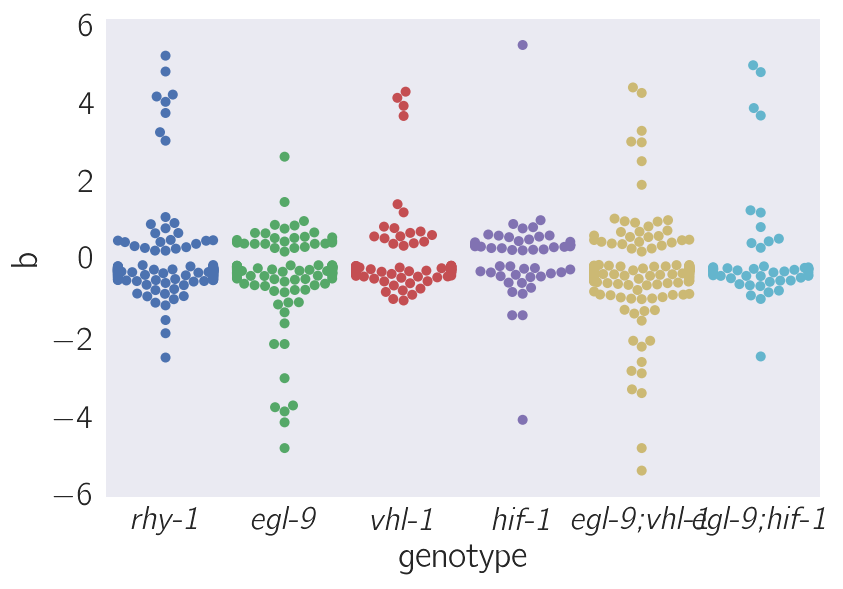

In [9]:
ax, mito = seqplotter.plot_by_term('mitochondrion', df=tidy_data,
                                   kind='go', swarm=True)

Visually, it looks like maybe 1/3 of the mitochondrial genes go up, and the rest go down. What genes are most represented in this pathway? How many points consistently show up in mutants that have a constitutive HIF-1 response? Let's find out.

Next, I find out what genes that are annotated with the term 'mitochondria' go up across genotypes with a constitutive HIF-1 response:

In [10]:
common  = epi.find_overlap(['e', 'b', 'd', 'a'], tidy_data)
trial = tidy_data[(tidy_data.ens_gene.isin(mito)) &
                  (tidy_data.target_id.isin(common)) &
                  (tidy_data.b > 0)].ext_gene
gene_compactifier(trial)

Gene "Family", Number Found
fum,  4 ['1', '1', '1', '1']
mai,  4 ['1', '1', '1', '1']
tomm-40
pcca,  4 ['1', '1', '1', '1']
oxa-1
F20D6.11
acl,  4 ['6', '6', '6', '6']
sdha,  4 ['1', '1', '1', '1']
phb-1


What about the genes that go DOWN in all genotypes with a constitutive HIF-1 response?

In [11]:
trial = tidy_data[(tidy_data.ens_gene.isin(mito)) &
                  (tidy_data.target_id.isin(common)) &
                  (tidy_data.b < 0)].ext_gene
gene_compactifier(trial)

Gene "Family", Number Found
nduf,  4 ['7', '7', '7', '7']
C25H3.9,  5 ['', '', '', '', '']
F09F7.4,  6 ['', '', '', '', '', '']
C05C10.3,  6 ['', '', '', '', '', '']
wah,  5 ['1', '1', '1', '1', '1']
Y54F10AM.5,  5 ['', '', '', '', '']
Y39E4A.3,  4 ['', '', '', '']
mdh,  4 ['2', '2', '2', '2']
tomm,  8 ['22', '22', '22', '22', '40', '40', '40', '40']
F20D6.11,  5 ['', '', '', '', '']
mrpl,  16 ['2', '2', '2', '2', '47', '47', '47', '47', '47', '47', '47', '47', '9', '9', '9', '9']
phb,  8 ['1', '1', '1', '1', '2', '2', '2', '2']
got,  4 ['2.1', '2.1', '2.1', '2.1']
mrps,  4 ['6', '6', '6', '6']
cyc,  4 ['1', '1', '1', '1']
sucl,  4 ['1', '1', '1', '1']
F54D5.12,  6 ['', '', '', '', '', '']
ZK669.4,  4 ['', '', '', '']
acdh,  5 ['1', '1', '1', '1', '1']
timm,  4 ['23', '23', '23', '23']
mtss,  4 ['1', '1', '1', '1']
nuo,  8 ['1', '1', '1', '1', '6', '6', '6', '6']
C14B9.10,  5 ['', '', '', '', '']
sco,  4 ['1', '1', '1', '1']
hsp,  6 ['60', '60', '60', '60', '60', '60']
atp,  4 ['5', '5

# HIF-1 effects on the ribosome

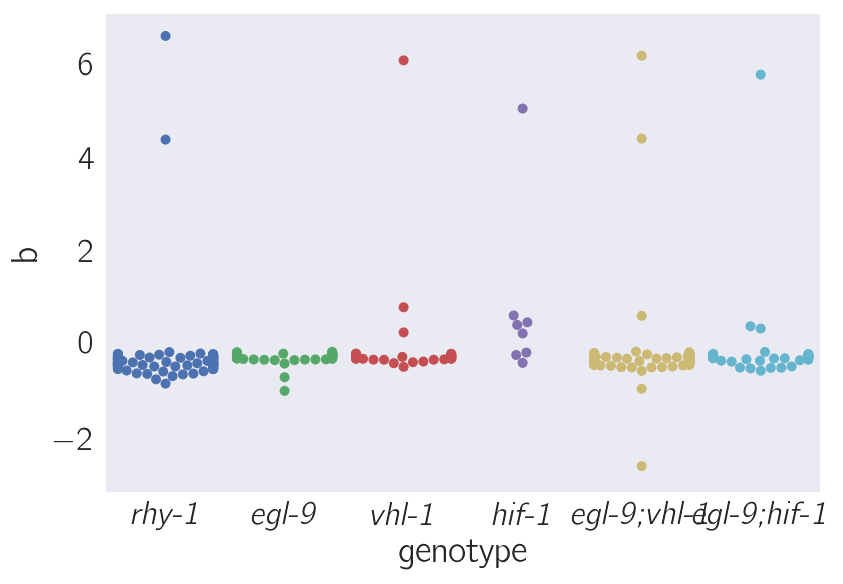

In [12]:
term = 'structural constituent of ribosome GO:0003735'
ax, ribosome = seqplotter.plot_by_term(term, df=tidy_data, kind='go')

In [13]:
trial = tidy_data[(tidy_data.ens_gene.isin(ribosome)) & (tidy_data.qval < q)].ext_gene.unique()
gene_compactifier(trial)

Gene "Family", Number Found
W01D2.1
ubl-1
C37A2.7
rla,  3 ['0', '1', '2']
T07A9.14
rpl,  41 ['1', '10', '11.1', '11.2', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24.1', '24.2', '25.1', '25.2', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '36', '38', '39', '4', '41', '43', '5', '6', '7', '9']
rps,  28 ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '26', '27', '28', '29', '3', '30', '4', '5', '6', '7', '8', '9']
Y37E3.8
F54D7.6
F54D7.7
mrps,  16 ['12', '14', '15', '16', '17', '18B', '18C', '21', '22', '23', '24', '25', '34', '6', '7', '9']
dap-3
mrpl,  18 ['10', '11', '12', '13', '15', '16', '17', '19', '2', '23', '24', '32', '34', '41', '47', '49', '51', '9']
ubq-2


# Bioenergetics of HIF-1

What about the effects of HIF-1 on the Electron Transport Chain? Or the TCA cycle?

To explore this, I will make a new dataframe, that contains only the genes in the ETC. I will also annotate each gene with the complex it belongs to, and then I will add a column called sort_order so I can sort the dataframe at my pleasure.

In [14]:
resp = tidy_data[tidy_data.ens_gene.isin(respiratory_complexes.ens_gene) 
                 & (~tidy_data.code.isin(['f', 'c']))].copy()

f = lambda x: respiratory_complexes[respiratory_complexes.ens_gene == x].complex.values[0]
resp['complex'] = resp.ens_gene.map(f)

f = lambda x: respiratory_complexes[respiratory_complexes.ens_gene == x].sort_order.values[0]
resp['sort_order'] = resp.ens_gene.map(f)
resp.sort_values('sort_order', inplace=True)
resp = resp[resp.complex != 'Ubiquinone Biosynthesis']

This is what the dataframe looks like:

In [15]:
resp[['ext_gene', 'genotype', 'complex', 'sort_order']].head()

,ext_gene,genotype,complex,sort_order
13466,mdh-1,\emph{egl-9},TCA,0
16268,fum-1,\emph{egl-9},TCA,0
16269,fum-1,\emph{egl-9},TCA,0
13019,idha-1,\emph{egl-9},TCA,0
10320,sucl-2,\emph{egl-9;vhl-1},TCA,0


Let's plot the dataframe, see what comes out. We would expect all genes in the ETC and TCA to go down:

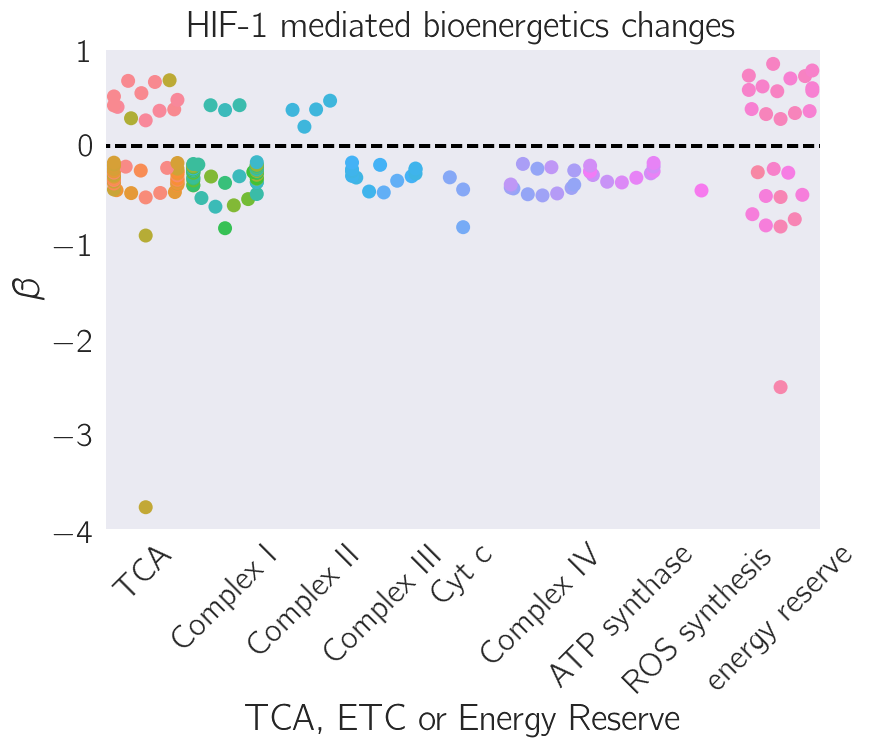

In [16]:
fig, ax = plt.subplots()
ax = sns.swarmplot(x='complex', y='b', hue='ens_gene', data=resp, size=7)
plt.xticks(rotation=45)
ax.legend_.remove()
plt.title('HIF-1 mediated bioenergetics changes')
plt.ylabel(r'\beta')
plt.xlabel('TCA, ETC or Energy Reserve')
ax.hlines(0, xmin=-2, xmax=10, lw=2, linestyle='--')
plt.ylim(-4, 1)
plt.savefig('../output/mito_function.pdf')

Well, we can definitely see that not all genes in the ETC and TCA go down. Let's figure out what genes go UP in each cycle/complex.

In [17]:
gene_compactifier(resp[(resp.complex == 'TCA') & (resp.b > 0)].ext_gene)

Gene "Family", Number Found
mdh,  4 ['1', '1', '1', '1']
fum,  6 ['1', '1', '1', '1', '1', '1']
sdhd-1
ogdh-1
idhg-1
sucl-2


In [18]:
gene_compactifier(resp[(resp.complex == 'Complex I') & (resp.b > 0)].ext_gene)

Gene "Family", Number Found
nuo,  5 ['2', '2', '3', '3', '3']
nduo-4


In [19]:
gene_compactifier(resp[(resp.complex == 'Complex II') & (resp.b > 0)].ext_gene)

Gene "Family", Number Found
sdha,  4 ['1', '1', '1', '1']


In [21]:
gene_compactifier(resp[(resp.complex == 'energy reserve') & (resp.b > 0)].ext_gene)

Gene "Family", Number Found
aagr-1
T04A8.7,  3 ['', '', '']
ogt,  4 ['1', '1', '1', '1']
T22F3.3,  5 ['', '', '', '', '']
agl,  3 ['1', '1', '1']


Notice that for complex I, the genes *nuo-2* and *nduo-4* are up-regulated. But those exact same genes are also down-regulated (see below). Therefore, there is insufficient information to conclude whether these genes are going up, or down as a result of HIF-1. However, for other genes, namely *fum-1* and *sdha-1* we can conclude that those are significantly and consistently up-regulated in mutants that have a constitutive HIF-1 mutant.

In [22]:
gene_compactifier(resp[(resp.complex == 'TCA') & (resp.b < 0)].ext_gene)

Gene "Family", Number Found
mdh,  4 ['2', '2', '2', '2']
dlst,  3 ['1', '1', '1']
sucl,  6 ['1', '1', '1', '1', '2', '2']
idh,  3 ['2', '2', '2']
icl-1
cts,  3 ['1', '1', '1']
idhg,  2 ['1', '1']
aco,  4 ['1', '1', '1', '2']
idha,  2 ['1', '1']
suca,  3 ['1', '1', '1']
sucg,  4 ['1', '1', '1', '1']


In [23]:
gene_compactifier(resp[(resp.complex == 'Complex I') & (resp.b < 0)].ext_gene)

Gene "Family", Number Found
F44G4.2
nuo,  10 ['1', '1', '1', '1', '2', '4', '6', '6', '6', '6']
T20H4.5,  3 ['', '', '']
F59C6.5
Y54F10AM.5,  4 ['', '', '', '']
Y69A2AR.3
F53F4.10,  4 ['', '', '', '']
Y63D3A.7
C33A12.1
Y53G8AL.2,  4 ['', '', '', '']
F45H10.3,  4 ['', '', '', '']
C25H3.9,  4 ['', '', '', '']
gas,  3 ['1', '1', '1']
nduf,  5 ['5', '7', '7', '7', '7']
djr-1.1
C18E9.4,  2 ['', '']
ndfl-4
nduo,  5 ['1', '1', '2', '3', '4']


In [24]:
gene_compactifier(resp[(resp.complex == 'energy reserve') & (resp.b < 0)].ext_gene)

Gene "Family", Number Found
aagr,  7 ['1', '1', '1', '2', '2', '2', '2']
gsy-1
T04A8.7
R05F9.6
Y67D8A.2


# Effects of HIF-1 on the Proteasome and Mediator

In [25]:
prot = tidy_data[tidy_data.ens_gene.isin(central_dogma.ens_gene)].copy()
prot['complex'] = prot.ens_gene.map(lambda x: central_dogma[central_dogma.ens_gene == x].complex.values[0])

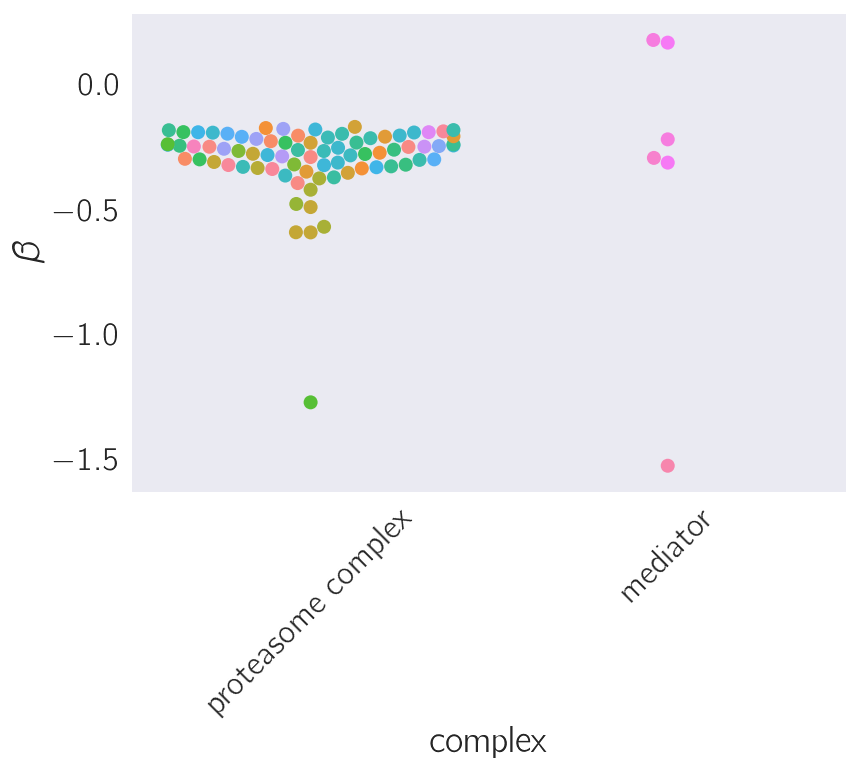

In [26]:
fig, ax = plt.subplots()
ax = sns.swarmplot(x='complex', y='b', hue='ens_gene', data=prot, size=7)
plt.xticks(rotation=45)
ax.legend_.remove()
# plt.title('HIF-1 mediated changes in ETC expression')
plt.ylabel(r'\beta')
# plt.xlabel('Electron Transport Chain Complexes')

## Effect of HIF-1 on proteins involved in 'protein catabolic process'
This GO term includes proteins that are involved in protein degradation, including the proteasome, a variety of ubiquitin-related enzymes and proteases

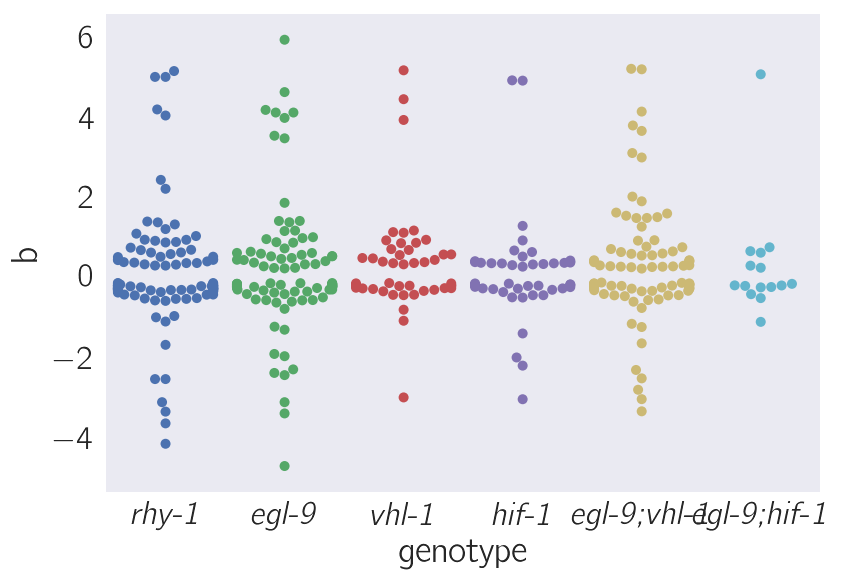

In [27]:
ax, negregproteolysis = seqplotter.plot_by_term('protein catabolic process GO:0030163',
                                                df=tidy_data, kind='go')

In [28]:
temp = tidy_data[(tidy_data.ens_gene.isin(negregproteolysis)) &
                 (tidy_data.target_id.isin(common)) &
                 (tidy_data.b > 0)
                ].ext_gene.unique()
gene_compactifier(temp)

Gene "Family", Number Found
K10C2.1
ctsa-2
mans-4
asp,  3 ['14', '5', '8']
aex-5
cpr,  2 ['1', '3']
zyx-1
uev-3


In [29]:
temp = tidy_data[(tidy_data.ens_gene.isin(negregproteolysis)) &
                 (tidy_data.target_id.isin(common)) &
                 (tidy_data.b < 0)
                ].ext_gene.unique()
gene_compactifier(temp)

Gene "Family", Number Found
pas-1
ubh-3
ubc-20
asp,  2 ['14', '8']
pbs-4
Y119C1B.5
F57F5.1
ubq-2
cpz-1
unc-60
rpn-3
uev-3
mans-3
cpr-6
Y66D12A.9
cpl-1
rpt-6


# Proteins annotated as involved in protein folding

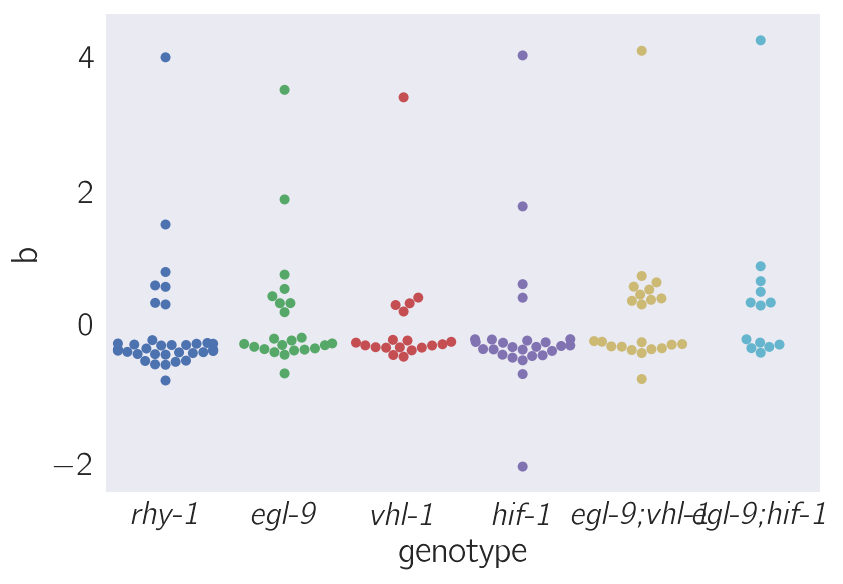

In [30]:
ax, folding = seqplotter.plot_by_term('protein folding', df=tidy_data, kind='go')

In [31]:
temp = tidy_data[(tidy_data.ens_gene.isin(folding)) & (tidy_data.b > 0)].ext_gene.unique()
gene_compactifier(temp)

Gene "Family", Number Found
fkb,  3 ['4', '5', '8']
daf-21
Y49E10.4
hsp-6
C34C12.8
T10H10.2
ZK973.11
sig-7
cyn,  3 ['5', '6', '8']
F42G8.7
enpl-1
F35G2.1


In [32]:
temp = tidy_data[(tidy_data.ens_gene.isin(folding)) & (tidy_data.b < 0)].ext_gene.unique()
gene_compactifier(temp)

Gene "Family", Number Found
bag-1
fkb,  2 ['2', '6']
emc-6
daf-21
Y22D7AL.10
hsp,  2 ['6', '60']
cdc-37
dpy-11
C34C12.8
dnj,  4 ['12', '13', '19', '20']
nud-1
trx-2
cyn,  5 ['1', '2', '3', '5', '7']
tbcd-1
txl-1
cct,  4 ['1', '3', '5', '7']
pfd,  5 ['1', '2', '4', '5', '6']


# Immune Involvement

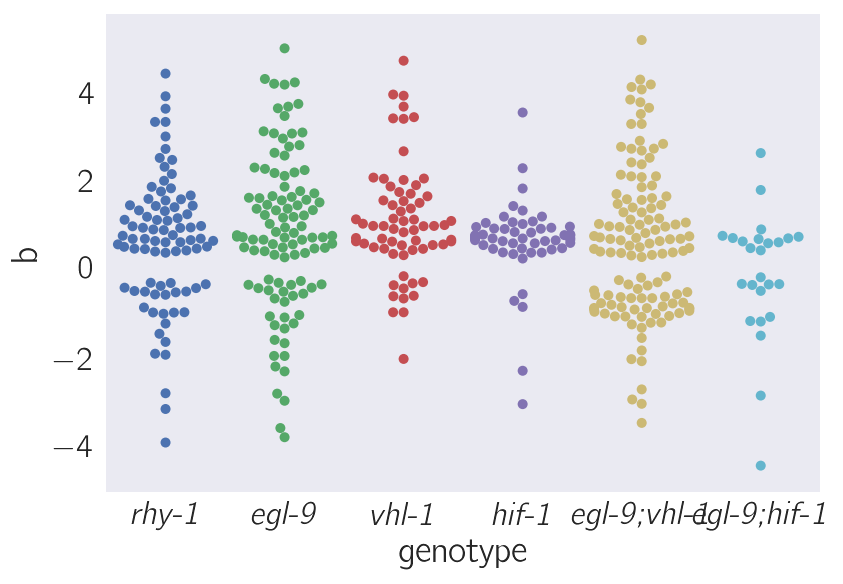

In [33]:
ax, immune = seqplotter.plot_by_term('immune system process', df=tidy_data, kind='go')

In [34]:
temp = tidy_data[(tidy_data.ens_gene.isin(immune)) & (tidy_data.target_id.isin(common)) &
                 (tidy_data.b > 0)].ext_gene.unique()
gene_compactifier(temp)

Gene "Family", Number Found
lec-11
lys,  2 ['2', '7']
C25D7.5
F01D5.1
F01D5.5
C34H4.2
C17H12.8
C49C3.9
gst-7
nhr-57
K08D8.4
F55G11.2
dod,  2 ['22', '24']
fat-3
his-10
clec,  4 ['210', '66', '70', '72']
F53A9.6
F55G11.8
tag-244
Y41D4B.17
T24B8.5
asp-14
dct-17
cpr-3
F35E12.9


In [34]:
temp = tidy_data[(tidy_data.ens_gene.isin(immune)) & (tidy_data.target_id.isin(common)) &
                 (tidy_data.b < 0)].ext_gene.unique()
gene_compactifier(temp)

Gene "Family", Number Found
F55G11.2
aqp-10
acdh-1
cyp-35A5
